###**Start**

In [1]:
!pip install omegaconf dacite xlstm

In [2]:
# restart notebook

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from omegaconf import OmegaConf
from pprint import pprint
from dacite import from_dict
from dacite import Config as DaciteConfig
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math

In [5]:
from xlstm.xlstm_block_stack import xLSTMBlockStack, xLSTMBlockStackConfig

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [6]:
device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device_

device(type='cpu')

In [8]:
# display options
pd.set_option('display.max_columns', None)

In [9]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [10]:
# read data
df = pd.read_csv("/content/drive/Shareddrives/Projects/Research/LSTM_vs_xLSTM/ETTm1.csv")

In [11]:
df.shape

(69680, 8)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69680 entries, 0 to 69679
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    69680 non-null  object 
 1   HUFL    69680 non-null  float64
 2   HULL    69680 non-null  float64
 3   MUFL    69680 non-null  float64
 4   MULL    69680 non-null  float64
 5   LUFL    69680 non-null  float64
 6   LULL    69680 non-null  float64
 7   OT      69680 non-null  float64
dtypes: float64(7), object(1)
memory usage: 4.3+ MB


In [13]:
df['date'] = pd.to_datetime(df['date'])

In [14]:
df.set_index('date', inplace=True)

In [15]:
df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


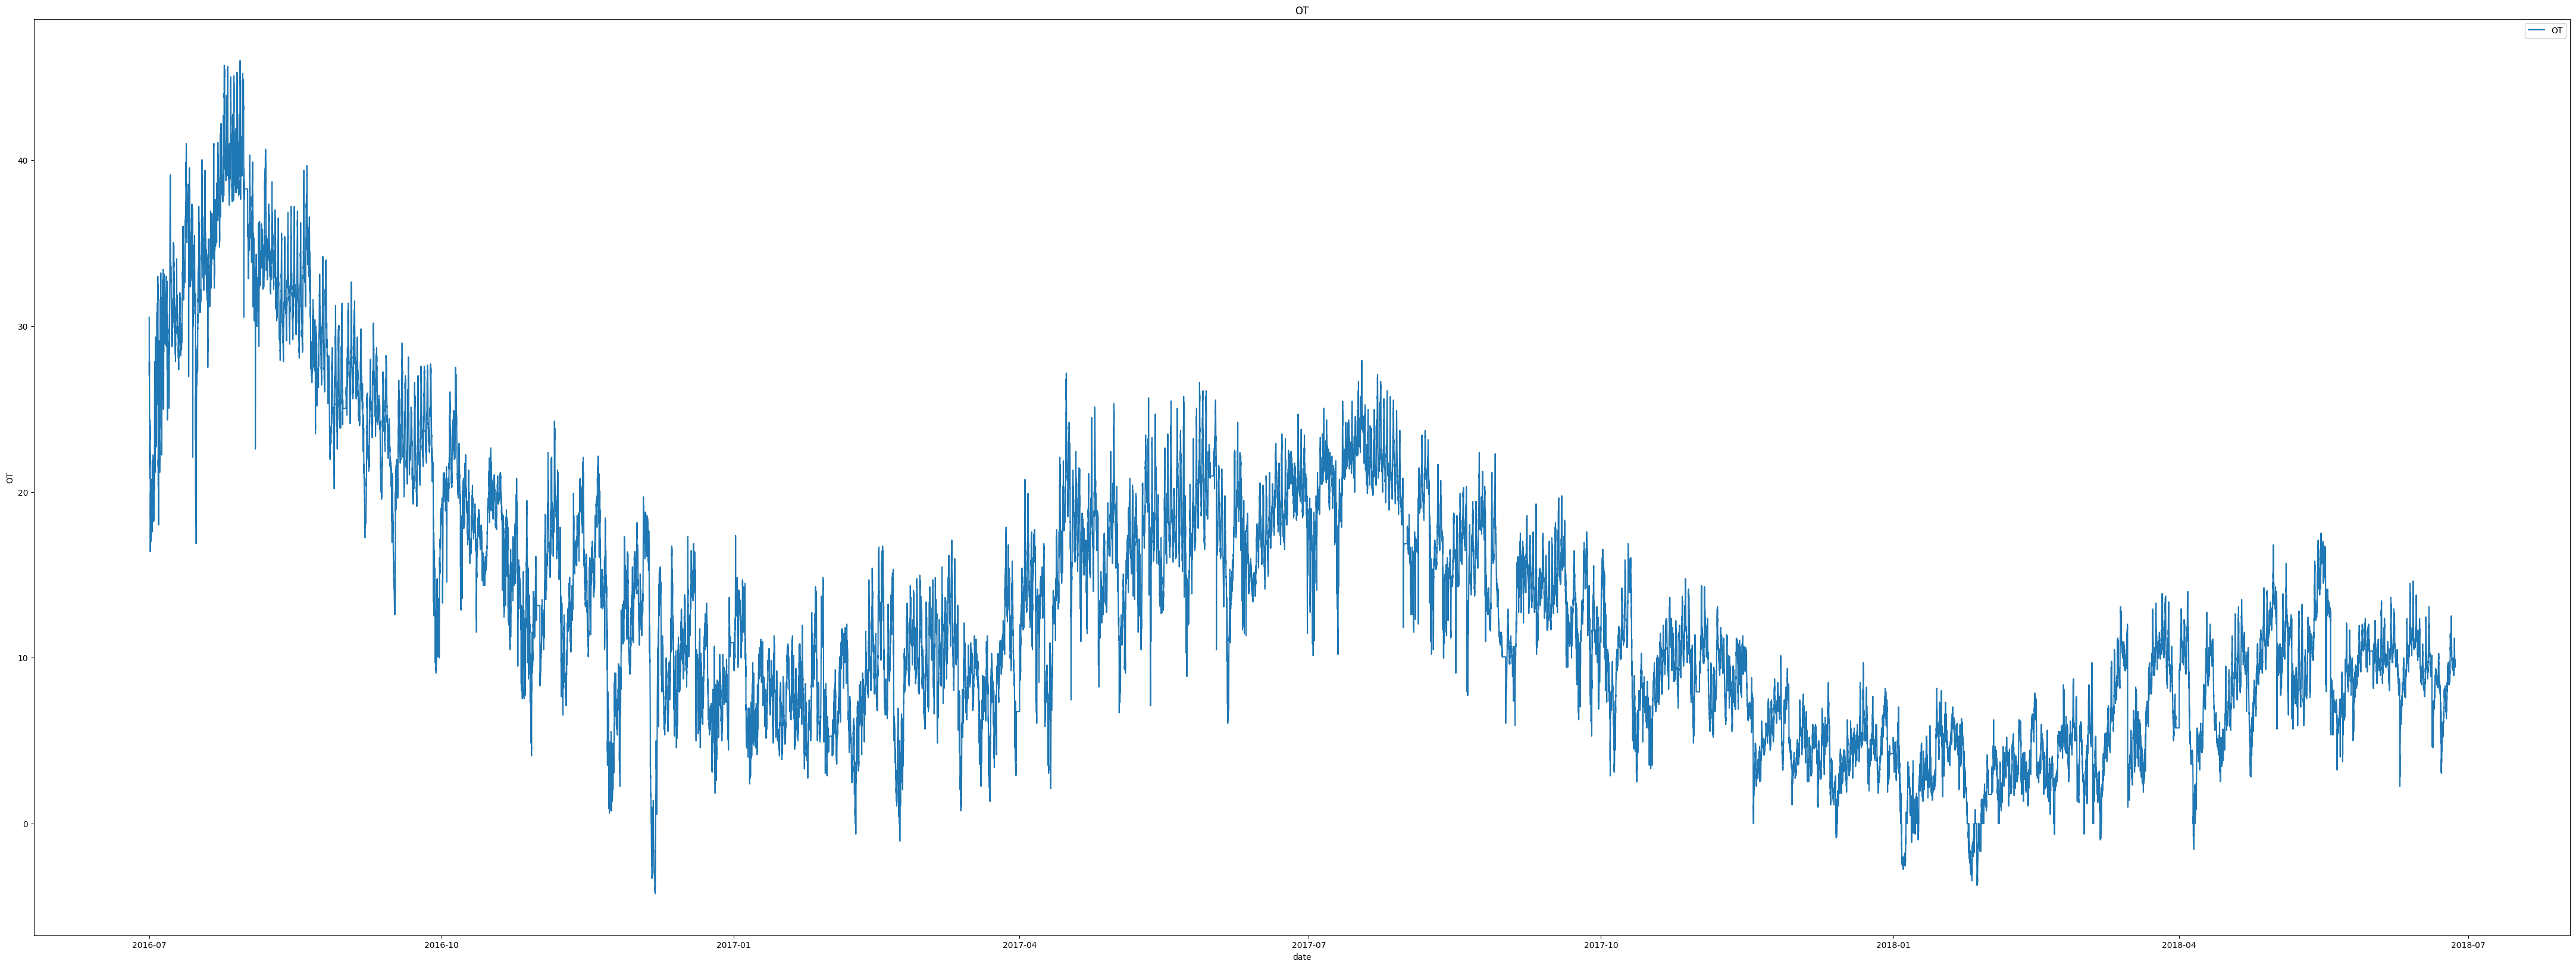

In [16]:
plt.figure(figsize=(55, 20))
sns.lineplot(data=df, x=df.index, y="OT", label="OT")
plt.xlabel('date')
plt.ylabel('OT')
plt.title('OT')
plt.autoscale(enable=True)
plt.legend()
plt.show()

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))

In [18]:
data = df.values

In [19]:
len(data)*0.7

48776.0

In [20]:
len_df = len(data)
df_train = data[:int(len_df*0.7)]
df_valid = data[int(len_df*0.7):int(len_df*0.9)]
df_test = data[int(len_df*0.9):len_df]

In [21]:
df_train.shape

(48776, 7)

In [22]:
df_valid.shape

(13936, 7)

In [23]:
df_test.shape

(6968, 7)

In [24]:
train_scaled = scaler.fit_transform(df_train)
val_scaled = scaler.transform(df_valid)
test_scaled = scaler.transform(df_test)

In [25]:
# import pickle

# with open('min_max_scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

In [26]:
train_scaled.shape

(48776, 7)

In [27]:
val_scaled.shape

(13936, 7)

In [28]:
test_scaled.shape

(6968, 7)

In [29]:
window_size=24
output_size=1
target_column_index=6
batch_size=64

In [30]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_index, window_size):
        self.data = data
        self.target_index = target_index
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.window_size]
        y = self.data[idx + self.window_size, self.target_index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


train_dataset = TimeSeriesDataset(train_scaled, target_column_index, window_size)
val_dataset = TimeSeriesDataset(val_scaled, target_column_index, window_size)
test_dataset = TimeSeriesDataset(test_scaled, target_column_index, window_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 24, 7])
Labels batch shape: torch.Size([64])


###**xLSTM**

In [32]:
xlstm_cfg = f"""
mlstm_block:
  mlstm:
    conv1d_kernel_size: 4
    qkv_proj_blocksize: 4
    num_heads: 4
slstm_block:
  slstm:
    backend: {'cuda' if torch.cuda.is_available() else 'vanilla'} #! only vanilla here works
    num_heads: 1
    conv1d_kernel_size: 4
    bias_init: powerlaw_blockdependent
  feedforward:
    proj_factor: 1.3
    act_fn: gelu
context_length: 24
num_blocks: 4
embedding_dim: 7
dropout: 0.2
slstm_at: [0,1,2,3] #[1] # for [] it also works, so if no sLSTM is in the stack
"""

In [33]:
cfg = OmegaConf.create(xlstm_cfg)
cfg = from_dict(data_class=xLSTMBlockStackConfig, data=OmegaConf.to_container(cfg), config=DaciteConfig(strict=True))
# pprint(cfg)

In [34]:
class xlstm(torch.nn.Module):
    def __init__(self, features, config):

        super(xlstm, self).__init__()

        self.features = features

        self.xlstm_stack = xLSTMBlockStack(config)

        self.mm= nn.Linear(self.features, 1)

        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.xlstm_stack(x)

        x=self.mm(x[:,-1,:])

        x = self.sigmoid(x)

        return x

In [35]:
n_features = train_features.size()[-1]
xlstm_model =  xlstm(n_features, cfg)

In [36]:
xlstm_model

xlstm(
  (xlstm_stack): xLSTMBlockStack(
    (blocks): ModuleList(
      (0-3): 4 x sLSTMBlock(
        (xlstm_norm): LayerNorm()
        (xlstm): sLSTMLayer(
          (conv1d): CausalConv1d(
            (conv): Conv1d(7, 7, kernel_size=(4,), stride=(1,), padding=(3,), groups=7)
          )
          (conv_act_fn): SiLU()
          (fgate): LinearHeadwiseExpand(in_features=7, num_heads=1, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (igate): LinearHeadwiseExpand(in_features=7, num_heads=1, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (zgate): LinearHeadwiseExpand(in_features=7, num_heads=1, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (ogate): LinearHeadwiseExpand(in_features=7, num_heads=1, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (slstm_cell): sLSTMCell_vanilla(function=slstm, hidden_size=7, num_heads=1)
     

In [37]:
xlstm_model = xlstm_model.to(device_)

In [38]:
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(xlstm_model.parameters(), lr=1e-4)

In [39]:
train_loss_list = []
val_loss_list = []

In [40]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [41]:
def validate_xlstm(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for itr in val_loader:
            inputs, targets = itr[0], itr[1]

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            val_loss += loss.item()

    return val_loss / len(val_loader)

In [42]:
def train_xlstm(model, train_loader, val_loader, num_epochs, patience, criterion, device):
    train_loss_list.clear()
    val_loss_list.clear()

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for itr in train_loader:
            inputs, targets = itr[0], itr[1]

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            # print(targets)
            # print(outputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            # print(loss.item())

        train_loss_for_epoch = train_loss/len(train_loader)
        val_loss_for_epoch = validate_xlstm(model, val_loader, criterion_mse, device)

        train_loss_list.append(round(train_loss_for_epoch, 4))
        val_loss_list.append(round(val_loss_for_epoch, 4))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_for_epoch:.4f}, Val Loss: {val_loss_for_epoch:.4f}')

        early_stopping(val_loss_for_epoch)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

In [43]:
train_xlstm(xlstm_model, train_loader, val_loader, 25, 5, criterion_mse, device_)

Epoch 1/25, Train Loss: 0.0205, Val Loss: 0.0233
Epoch 2/25, Train Loss: 0.0171, Val Loss: 0.0198
Epoch 3/25, Train Loss: 0.0137, Val Loss: 0.0166
Epoch 4/25, Train Loss: 0.0119, Val Loss: 0.0145
Epoch 5/25, Train Loss: 0.0109, Val Loss: 0.0130
Epoch 6/25, Train Loss: 0.0101, Val Loss: 0.0118
Epoch 7/25, Train Loss: 0.0094, Val Loss: 0.0107
Epoch 8/25, Train Loss: 0.0090, Val Loss: 0.0099
Epoch 9/25, Train Loss: 0.0084, Val Loss: 0.0091
Epoch 10/25, Train Loss: 0.0080, Val Loss: 0.0087
Epoch 11/25, Train Loss: 0.0076, Val Loss: 0.0083
Epoch 12/25, Train Loss: 0.0072, Val Loss: 0.0079
Epoch 13/25, Train Loss: 0.0069, Val Loss: 0.0075
Epoch 14/25, Train Loss: 0.0066, Val Loss: 0.0072
Epoch 15/25, Train Loss: 0.0063, Val Loss: 0.0069
Epoch 16/25, Train Loss: 0.0059, Val Loss: 0.0067
Epoch 17/25, Train Loss: 0.0057, Val Loss: 0.0065
Epoch 18/25, Train Loss: 0.0054, Val Loss: 0.0063
Epoch 19/25, Train Loss: 0.0052, Val Loss: 0.0061
Epoch 20/25, Train Loss: 0.0049, Val Loss: 0.0060
Epoch 21/

In [44]:
def plot_learning_curves(train_loss, val_loss):
    plt.plot(np.arange(1, len(train_loss) + 1), train_loss, "b-", label="Training loss")
    plt.plot(np.arange(1, len(val_loss) + 1), val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")

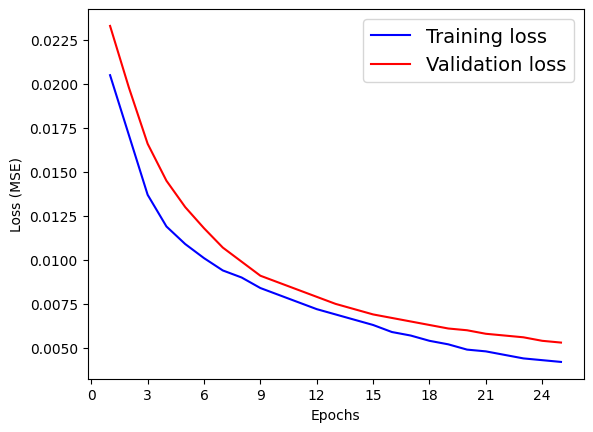

In [45]:
plot_learning_curves(train_loss_list, val_loss_list)
plt.show()

In [46]:
torch.save(xlstm_model.state_dict(), "/content/drive/Shareddrives/Projects/Research/LSTM_vs_xLSTM/ETTm1_xLSTM__ssss.pth")

In [47]:
# loading a model
# loaded_model =  xlstm(n_features, cfg)
# model_path = '/content/drive/Shareddrives/Projects/Research/LSTM_vs_xLSTM/ETTm1_xLSTM__sss.pth'
# loaded_model.load_state_dict(torch.load(model_path))
# loaded_model = loaded_model.to(device_)

In [48]:
actual_list = []
pred_list = []

In [49]:
def test_model(model, test_loader, criterion, device):
    actual_list.clear()
    pred_list.clear()

    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for itr in test_loader:
            inputs, targets = itr[0], itr[1]

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            out = outputs.squeeze()

            for outs in out:
              pred_list.append(outs.item())
            loss = criterion(outputs, targets)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

In [50]:
test_model(xlstm_model, test_loader, criterion_mse, device_)

Test Loss: 0.0031


In [51]:
test_model(xlstm_model, test_loader, criterion_mae, device_)

Test Loss: 0.0450


In [52]:
mx = scaler.data_max_[target_column_index]
mn = scaler.data_min_[target_column_index]
rng= scaler.data_range_[target_column_index]

In [53]:
len(pred_list)

6944

In [54]:
df_test.shape

(6968, 7)

In [55]:
print(mx, mn, rng)

46.00699996948242 -4.2210001945495605 50.22800016403198


In [56]:
df_test

array([[15.8739996 ,  1.94200003, 10.8739996 , ...,  4.78200006,
         0.82200003,  5.13500023],
       [16.07500076,  1.94200003, 10.5539999 , ...,  5.20800018,
         0.94400001,  5.34600019],
       [14.86999989,  1.54100001,  9.09700012, ...,  5.30000019,
         1.12699997,  5.69799995],
       ...,
       [10.7840004 ,  3.34899998,  7.        , ...,  3.74600005,
         1.43200004,  9.42599964],
       [11.65499973,  3.6170001 ,  7.53299999, ...,  4.17299986,
         1.523     ,  9.42599964],
       [12.99400043,  3.81800008,  8.24400043, ...,  4.72100019,
         1.523     ,  9.77799988]])

In [57]:
X_test = df_test[window_size:, target_column_index]
actual = pd.DataFrame(X_test, columns=['actual'])

In [58]:
actual.isnull().sum()

,0
actual,0


In [59]:
actual['predictions'] = pred_list
actual['predictions'] = actual['predictions']*rng+mn
actual['signed_difference'] = (actual['predictions'] - actual['actual'])
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

In [60]:
actual.shape

(6944, 5)

In [61]:
len_df-int(len_df*0.9)

6968

In [62]:
test_df = df[-actual.shape[0]:]
test_df.shape

(6944, 7)

In [63]:
test_df.shape

(6944, 7)

In [64]:
test_df['index'] = test_df.index

In [65]:
res_X_test = actual[["actual", "predictions","signed_difference","difference","difference_percentage"]]

In [66]:
test_df = test_df.reset_index(drop=True)
res_X_test = res_X_test.reset_index(drop=True)
df_All_final = pd.concat([test_df['index'], res_X_test[["actual", "predictions","signed_difference","difference","difference_percentage"]]], axis=1)

In [67]:
df_All_final["difference_sq"] = df_All_final["difference"] ** 2

In [68]:
df_All_final

,index,actual,predictions,signed_difference,difference,difference_percentage,difference_sq
0,2018-04-15 12:00:00,6.613,12.365758,5.752758,5.752758,86.991651,33.094223
1,2018-04-15 12:15:00,6.402,12.694018,6.292018,6.292018,98.282075,39.589496
2,2018-04-15 12:30:00,6.472,12.793241,6.321241,6.321241,97.670595,39.958088
3,2018-04-15 12:45:00,6.753,13.050553,6.297553,6.297553,93.255636,39.659172
4,2018-04-15 13:00:00,6.824,12.885433,6.061433,6.061433,88.825221,36.740970
...,...,...,...,...,...,...,...
6939,2018-06-26 18:45:00,9.567,6.324552,-3.242449,3.242449,33.892008,10.513473
6940,2018-06-26 19:00:00,9.567,6.275845,-3.291156,3.291156,34.401126,10.831707
6941,2018-06-26 19:15:00,9.426,6.283330,-3.142670,3.142670,33.340440,9.876373
6942,2018-06-26 19:30:00,9.426,6.308603,-3.117397,3.117397,33.072319,9.718162


In [69]:
# results
print("Error, less than or equal to 5%: ", round((df_All_final['difference_percentage'] <= 5).sum()/df_All_final.shape[0]*100, 2), "%")
print("Error, less than or equal to 10%: ", round((df_All_final['difference_percentage'] <= 10).sum()/df_All_final.shape[0]*100, 2), "%")
print("MSE: ", round(df_All_final['difference_sq'].mean(), 2))
print("RMSE: ", round(math.sqrt(df_All_final['difference_sq'].mean()), 2))
print("MAE: ", round(df_All_final['difference'].mean(), 2))
print("Max error: ", round(df_All_final['difference'].max(), 2))

Error, less than or equal to 5%:  11.72 %
Error, less than or equal to 10%:  23.0 %
MSE:  6.38
RMSE:  2.53
MAE:  2.05
Max error:  8.71


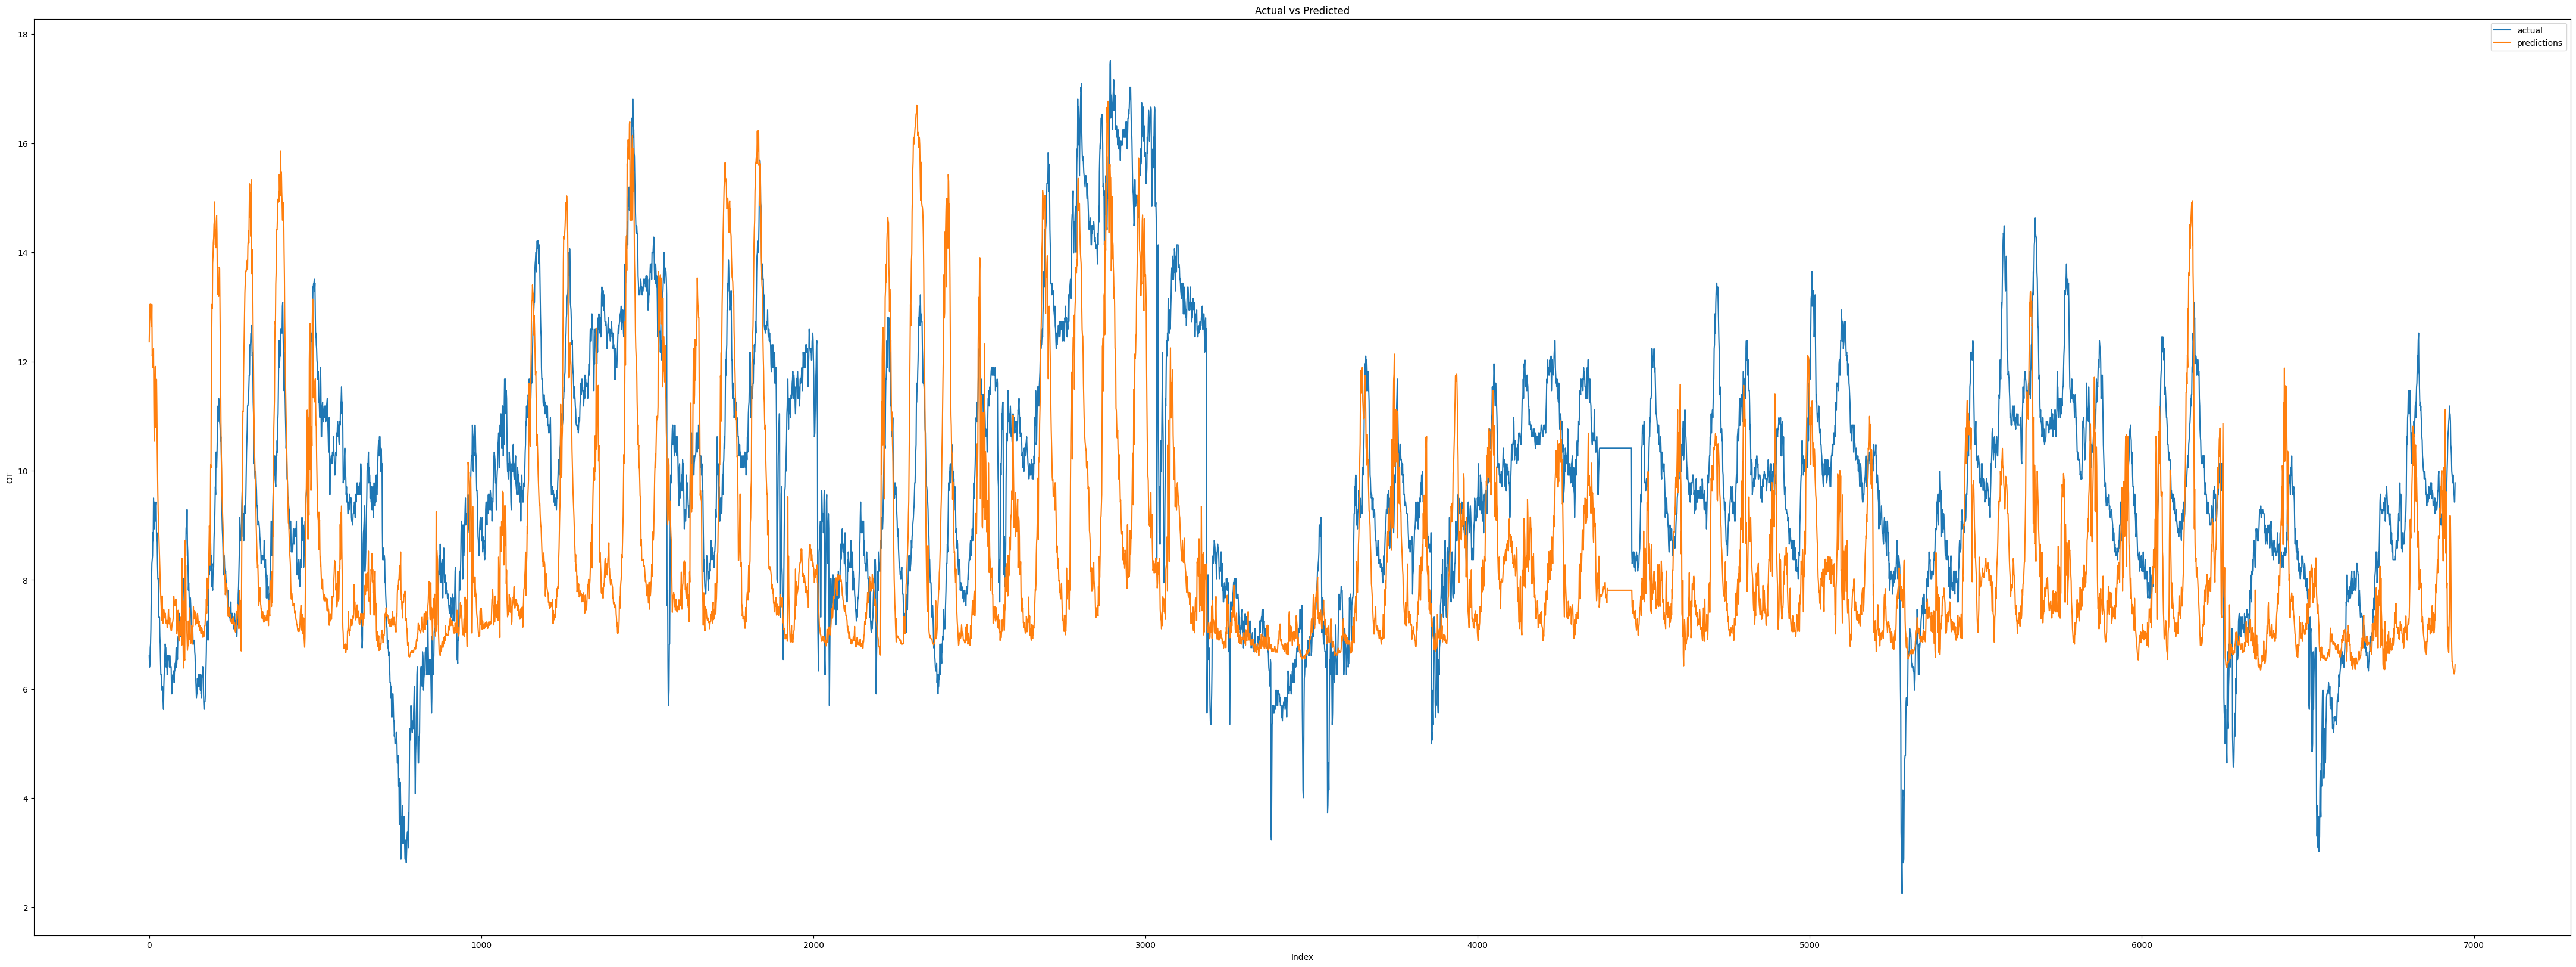

In [70]:
plt.figure(figsize=(55, 20))
sns.lineplot(data=df_All_final, x=df_All_final.index, y="actual", label="actual")
sns.lineplot(data=df_All_final, x=df_All_final.index, y="predictions", label="predictions")
plt.xlabel('Index')
plt.ylabel('OT')
plt.title('Actual vs Predicted')
plt.autoscale(enable=True)
plt.legend()
plt.show()